## Libraries

In [147]:
#load libraries
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os as os
import panel as pn
import math

pn.extension()

## Functions

In [190]:
#intensity and sleep comparison
def intensity_sleep_plots(data, sleep_level="all",user_id="all"):
    #variables
    x_tick_fs=10
    y_tick_fs=10
    x_label_fs=12
    y_label_fs=12
    title_fs=14
    max_x=data["sleep_minutes"].max()
    max_y=data["intensity_minutes"].max()
    x_interval=math.ceil(max_x/20)
    y_interval=math.ceil(max_y/20)
    min_x=0-x_interval
    min_y=0-y_interval

    #corelation coefficient
    cor_matrix=data[["intensity_minutes","sleep_minutes"]].corr()
    cor_coef=round(cor_matrix.loc["intensity_minutes","sleep_minutes"],4)

    #level descriptions
    match sleep_level:
        case("all"):
            desc_sleep_level="All Sleep Levels"
        case(1):
            desc_sleep_level="Light Sleep Only"
        case(2):
            desc_sleep_level="Deep Sleep Only"
        case(3):
            desc_sleep_level="REM Sleep Only"

    match user_id:
        case("all"):
            desc_user_id="All Users"
        case _:
            desc_user_id=str(user_id)

    #scatter plot
    fig1, ax1=plt.subplots(figsize=(7,6))
    ax1.scatter(x=data["sleep_minutes"], y=data["intensity_minutes"])
    ax1.set_yticks(ticks=range(min_y,max_y+y_interval,y_interval))
    ax1.tick_params(axis="y", labelsize=y_tick_fs)
    ax1.set_ylim(min_y,max_y+y_interval)
    ax1.set_xticks(ticks=range(min_x,max_x+x_interval,x_interval))
    ax1.set_xlim(min_x,max_x+x_interval)
    ax1.tick_params(axis="x", labelsize=x_tick_fs,rotation=90)
    ax1.set_xlabel("Amount of Sleep (min)",fontweight="bold",fontsize=x_label_fs)
    ax1.set_ylabel("Amount of Activity (min)",fontweight="bold",fontsize=y_label_fs)
    ax1.set_title(f"Amount of Sleep vs. Amount of Activity\n {desc_sleep_level}, {desc_user_id}",fontweight="bold",fontsize=title_fs)
    ax1.annotate(f"Corr Coef: {cor_coef}",xy=(0.65,0.9),xycoords="axes fraction", color="red",fontsize=12, fontweight="bold")
    plt.close() 

    #plot histogram of sleep
    fig2, ax1=plt.subplots(figsize=(7,6))
    n, bins, patches=ax1.hist(data["sleep_minutes"],bins=25)
    ax1.set_xlim(min_x,max_x+x_interval)
    ax1.set_xticks(ticks=range(min_x,max_x+x_interval,math.ceil((max_x+x_interval)/25)))
    ax1.set_xlabel("Amount of Sleep Bin",fontweight="bold",fontsize=x_label_fs)
    ax1.tick_params(axis="x", rotation=90,labelsize=x_tick_fs)
    ax1.set_ylim(0,int(n.max())+math.ceil((int(n.max())/20)))
    ax1.set_yticks(ticks=range(0,int(n.max())+math.ceil((int(n.max())/20)),math.ceil(int(n.max())/20)))
    ax1.set_ylabel("Count",fontweight="bold",fontsize=y_label_fs)
    ax1.tick_params(axis="y",labelsize=y_tick_fs)
    ax1.set_title(f"Histogram of Amount of Sleep\n{desc_sleep_level}, {desc_user_id}", fontweight="bold",fontsize=title_fs)
    plt.close() 

    #plot histogram of activity
    fig3, ax1=plt.subplots(figsize=(7,6))
    n, bins, patches=ax1.hist(data["intensity_minutes"],bins=25)
    ax1.set_xlim(min_y,min_y+y_interval)
    ax1.set_xticks(ticks=range(min_y,max_y+y_interval,math.ceil((max_y+y_interval)/25)))
    ax1.set_xlabel("Amount of Activity Bin",fontweight="bold",fontsize=x_label_fs)
    ax1.tick_params(axis="x", rotation=90,labelsize=x_tick_fs)
    ax1.set_ylim(0,int(n.max())+math.ceil((int(n.max())/20)))
    ax1.set_yticks(ticks=range(0,int(n.max())+math.ceil((int(n.max())/20)),math.ceil(int(n.max())/20)))
    ax1.set_ylabel("Count",fontweight="bold", fontsize=y_label_fs)
    ax1.tick_params(axis="y",labelsize=y_tick_fs)
    ax1.set_title(f"Histogram of Amount of Activity\n{desc_sleep_level}, {desc_user_id}", fontweight="bold",fontsize=title_fs)
    plt.close() 

    
    return([fig1,fig2,fig3])

In [3]:
#get sleep data

def get_sleep_data(sleep_level, user_id):
    #load the dataframe
    df_sleep_minute=dataframes_dict['minuteSleep_merged'].copy()

    #convert date to date time, extract the date
    df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
    df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

    #filter to sleep level and user_id
    #convert inputs to int
    match (str(sleep_level).lower(), str(user_id).lower()):
        case("all","all"):
            pass #no filtering taking place
        case(_,"all"):
            sleep_level=int(sleep_level)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["value"]==sleep_level)]
        case("all",_):
            user_id=int(user_id)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["Id"]==user_id)]
        case _:
            sleep_level=int(sleep_level)
            user_id=int(user_id)
            df_sleep_minute=df_sleep_minute[(df_sleep_minute["value"]==sleep_level) & (df_sleep_minute["Id"]==user_id)]


    #remove duplicates (some of the 4/12 data is in both files)
    df_sleep_minute=df_sleep_minute.drop_duplicates()

    #find max date because logId spans midnight
    df_max_date_logid=df_sleep_minute.groupby(by=["logId"]).agg(
    max_date=("date2","max")).reset_index()

    #merge in max date with sleep data
    df_sleep_minute=pd.merge(df_sleep_minute,df_max_date_logid,
                             how="left",
                             on="logId")

    #group and aggregate
    df_sleep_day=df_sleep_minute.groupby(by=["Id","logId"]).agg(
        sleep_minutes=("value","count"),
        date=("max_date","max")).reset_index()

    #drop logId column amd reorder
    df_sleep_day=df_sleep_day.drop(columns=["logId"])
    df_sleep_day=df_sleep_day[["Id","date","sleep_minutes"]]

    return ([df_sleep_day,sleep_level,user_id])

## Code

In [4]:
#Loop to read in data and make dataframes

march_path="./data/march_april/"
april_path="./data/april_may/"

march_file_list=[file for file in os.listdir(march_path) if file.endswith('.csv')]

april_file_list=[file for file in os.listdir(april_path) if file.endswith('.csv')]

#function to check if march and april lists are identical
def compare_lists(list1,list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True


#loop to read files
dataframes_dict={}
if compare_lists(march_file_list,april_file_list)==True:
    for i in range(len(march_file_list)):
        dataframes_dict[march_file_list[i][:len(march_file_list[i])-4]]=pd.concat([pd.read_csv(march_path+march_file_list[i]),pd.read_csv(april_path+april_file_list[i])])
else: 
    print(f"Check to see if the same number of files are in each directory and if the names are the same.  compare= {compare_lists(march_file_list,april_file_list)}")                                                                                                


In [5]:
#get intensity data
#load the dataframe
df_intensity_minute=dataframes_dict['minuteIntensitiesNarrow_merged'].copy()

#convert ActivityMinute to date time and extract the date
df_intensity_minute["ActivityMinute"]=pd.to_datetime(df_intensity_minute["ActivityMinute"],format='%m/%d/%Y %I:%M:%S %p')
df_intensity_minute["date"]=df_intensity_minute["ActivityMinute"].dt.strftime('%Y-%m-%d')

#remove duplicates (some of the 4/12 data is in both files)
df_intensity_minute=df_intensity_minute.drop_duplicates()

#Remove rows where Intensity is 0 (0 is resting)
df_intensity_day=df_intensity_minute[df_intensity_minute["Intensity"] !=0]

#drop the ActivityMinute column and group by Id and date
df_intensity_day=df_intensity_day.drop(columns=["ActivityMinute"])
df_intensity_day=df_intensity_day.groupby(by=["Id","date"]).agg(intensity_minutes=("Intensity","count")).reset_index()

df_intensity_day.info()
display(df_intensity_day.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1688 non-null   int64 
 1   date               1688 non-null   object
 2   intensity_minutes  1688 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 39.7+ KB


,Id,date,intensity_minutes
1683,8877689391,2016-05-08,266
1684,8877689391,2016-05-09,309
1685,8877689391,2016-05-10,253
1686,8877689391,2016-05-11,313
1687,8877689391,2016-05-12,141


## Get Sleep Data

### Manual

In [ ]:
#get sleep data
#load the dataframe
df_sleep_minute=dataframes_dict['minuteSleep_merged'].copy()

#convert date to date time, extract the date
df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

#remove duplicates (some of the 4/12 data is in both files)
df_sleep_minute=df_sleep_minute.drop_duplicates()

#find max date because logId spans midnight
df_max_date_logid=df_sleep_minute.groupby(by=["logId"]).agg(
    max_date=("date2","max")).reset_index()

#merge in max date with sleep data
df_sleep_minute=pd.merge(df_sleep_minute,df_max_date_logid,
                      how="left",
                      on="logId")


#group and aggregate
df_sleep_day=df_sleep_minute.groupby(by=["Id","logId"]).agg(
    sleep_minutes=("value","count"),
    date=("max_date","max")).reset_index()

#drop logId column amd reorder
df_sleep_day=df_sleep_day.drop(columns=["logId"])
df_sleep_day=df_sleep_day[["Id","date","sleep_minutes"]]

df_sleep_day
 

### Function

In [6]:
# Function
sleep_level_request=input("Select the sleep level you would like to use.  Options are 1, 2, 3 or \"all\".")
                          
user_id_request=input("Input the user ID you are interested in or \"all\".")

df_sleep_day=get_sleep_data(sleep_level_request,user_id_request)[0]
sleep_level=get_sleep_data(sleep_level_request,user_id_request)[1]
user_id=get_sleep_data(sleep_level_request,user_id_request)[2]

df_sleep_day.head()

,Id,date,sleep_minutes
0,1503960366,2016-03-13,426
1,1503960366,2016-03-14,386
2,1503960366,2016-03-15,335
3,1503960366,2016-03-16,303
4,1503960366,2016-03-16,63


## Merge

In [7]:
#merge intensity and sleep data
df_intensity_sleep_day=pd.merge(df_intensity_day,df_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

df_intensity_sleep_day.info()
display(df_intensity_sleep_day.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1006 non-null   int64 
 1   date               1006 non-null   object
 2   intensity_minutes  1006 non-null   int64 
 3   sleep_minutes      1006 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.6+ KB


,Id,date,intensity_minutes,sleep_minutes
0,1503960366,2016-03-13,334,426
1,1503960366,2016-03-14,298,386
2,1503960366,2016-03-15,403,335
3,1503960366,2016-03-16,318,303
4,1503960366,2016-03-16,318,63


In [139]:
#display(df_intensity_sleep_day["sleep_minutes"].count())
#df_intensity_sleep_day["sleep_minutes"].count()
df_intensity_sleep_day

1006

## Plotting

### Manual

,intensity_minutes,sleep_minutes
intensity_minutes,1.000000,-0.002819
sleep_minutes,-0.002819,1.000000


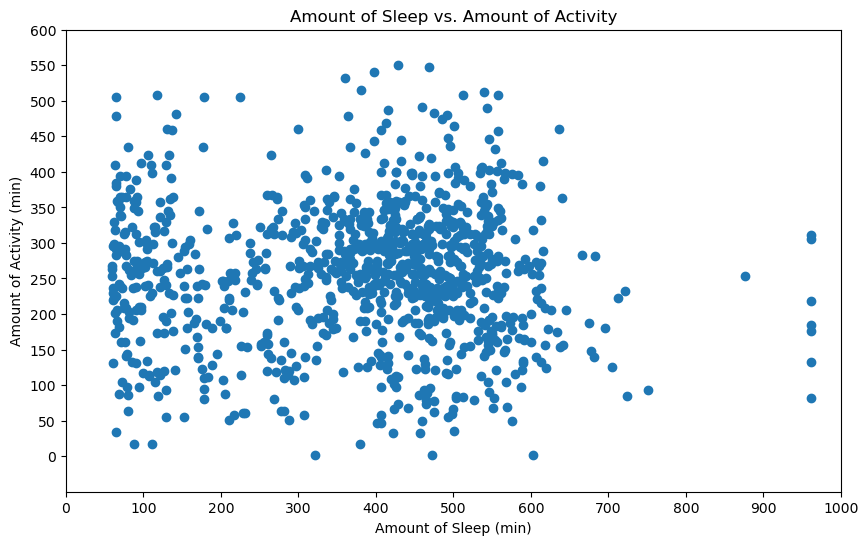

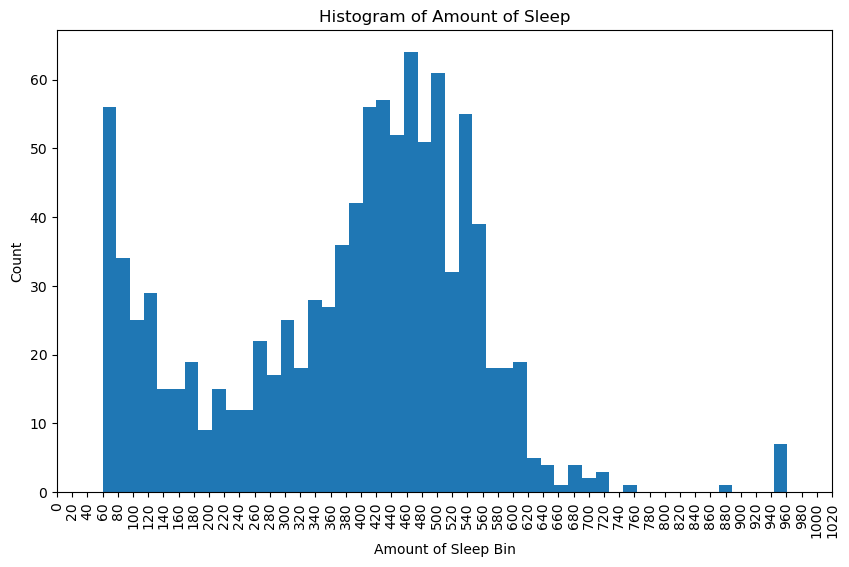

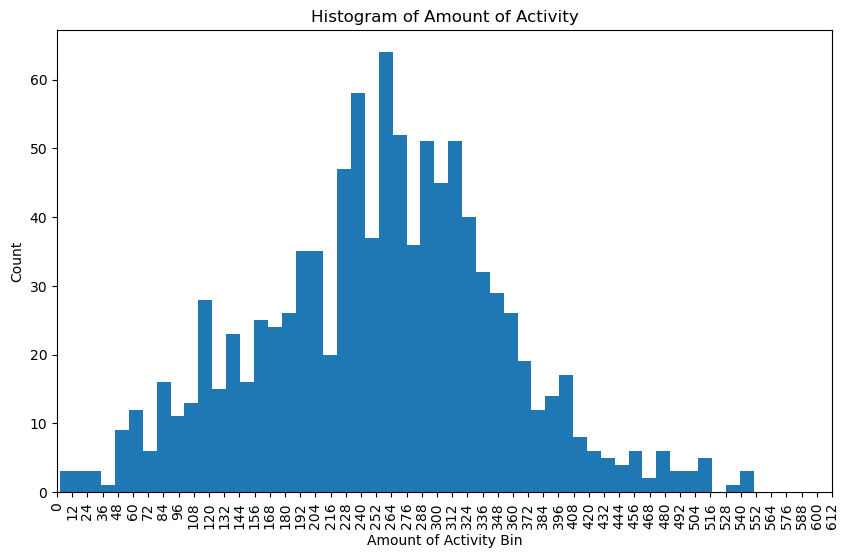

In [14]:
#find correlation coefficients
display(df_intensity_sleep_day[["intensity_minutes","sleep_minutes"]].corr())

#plot scatter
fig1, ax1=plt.subplots(figsize=(10,6))
ax1.scatter(x=df_intensity_sleep_day["sleep_minutes"], y=df_intensity_sleep_day["intensity_minutes"])
ax1.set_yticks(ticks=range(0,650,50))
ax1.set_ylim(-50,600)
ax1.set_xticks(ticks=range(0,1100,100))
ax1.set_xlim(0,1000)
ax1.set_xlabel("Amount of Sleep (min)")
ax1.set_ylabel("Amount of Activity (min)")
ax1.set_title("Amount of Sleep vs. Amount of Activity")
plt.show()

#plot histogram of sleep
fig2, ax1=plt.subplots(figsize=(10,6))
ax1.hist(df_intensity_sleep_day["sleep_minutes"],bins=50)
ax1.set_xlim(0,1000)
ax1.set_xticks(ticks=range(0,1021,20))
ax1.set_xlabel("Amount of Sleep Bin")
ax1.set_ylabel("Count")
ax1.set_title("Histogram of Amount of Sleep")
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)
plt.show()

#plot histogram of activity
fig3, ax1=plt.subplots(figsize=(10,6))
ax1.hist(df_intensity_sleep_day["intensity_minutes"],bins=50)
ax1.set_xlim(0,600)
ax1.set_xticks(ticks=range(0,613,12))
ax1.set_xlabel("Amount of Activity Bin")
ax1.set_ylabel("Count")
ax1.set_title("Histogram of Amount of Activity")
ax1.set_xticklabels(ax1.get_xticks(), rotation=90)
plt.show()

### Function

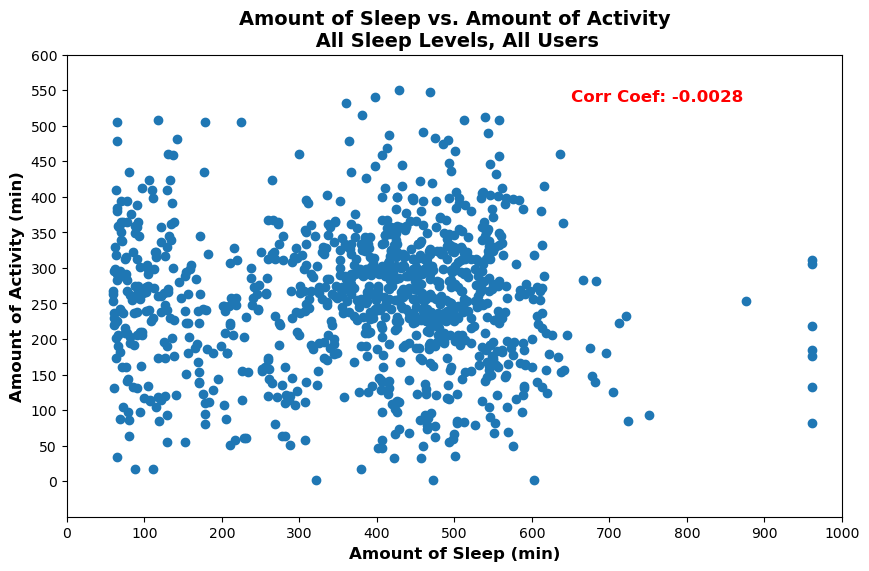

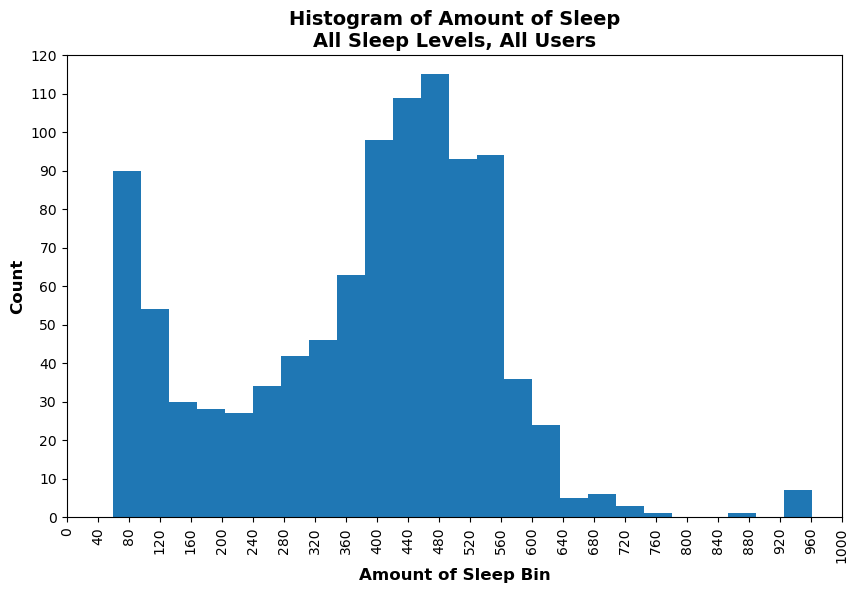

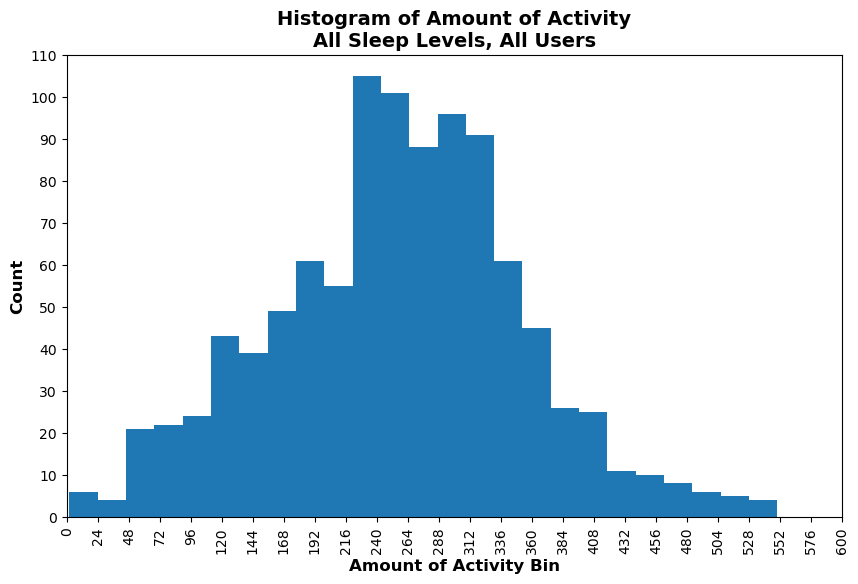

In [63]:
#plot using a function
intensity_sleep_figures=intensity_sleep_plots(df_intensity_sleep_day,sleep_level,user_id)


display(intensity_sleep_figures[0])
display(intensity_sleep_figures[1])
display(intensity_sleep_figures[2])

### Grid Space

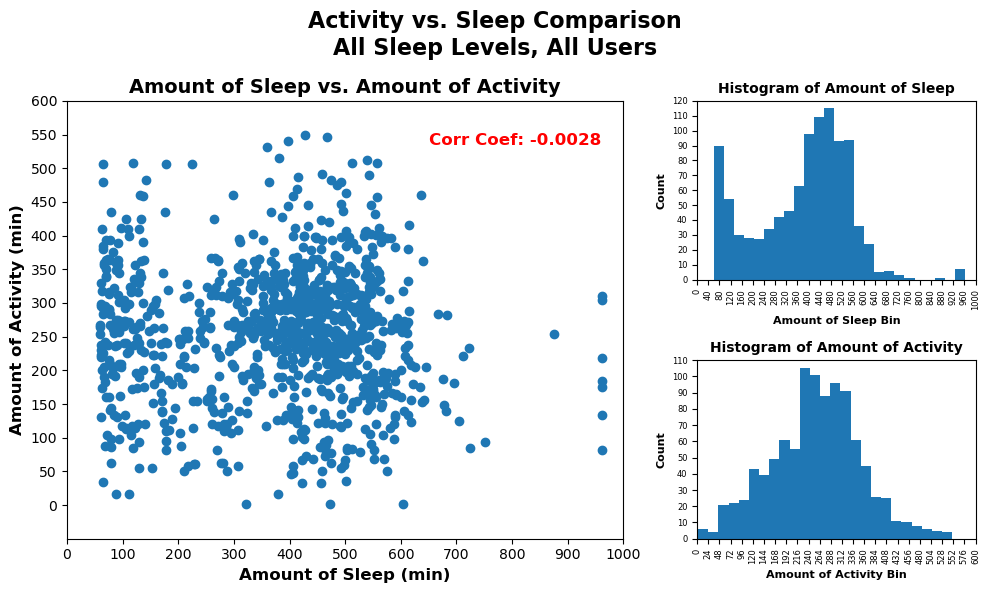

In [164]:
#plot using GridSpec
match sleep_level:
    case("all"):
        desc_sleep_level="All Sleep Levels"
    case(1):
        desc_sleep_level="Light Sleep Only"
    case(2):
        desc_sleep_level="Deep Sleep Only"
    case(3):
        desc_sleep_level="REM Sleep Only"

match user_id:
    case("all"):
        desc_user_id="All Users"
    case _:
        desc_user_id=str(user_id)

#corelation coefficient
cor_matrix=df_intensity_sleep_day[["intensity_minutes","sleep_minutes"]].corr()
cor_coef=round(cor_matrix.loc["intensity_minutes","sleep_minutes"],4)

#create figure
fig1=plt.figure(figsize=(10,6))
fig1.suptitle(f"Activity vs. Sleep Comparison\n{desc_sleep_level}, {desc_user_id}", fontweight="bold", fontsize=16)

#define GridSpec
gs=fig1.add_gridspec(2,2, width_ratios=[2,1])

#plot scatter
ax1=fig1.add_subplot(gs[:,0])
ax1.scatter(x=df_intensity_sleep_day["sleep_minutes"], y=df_intensity_sleep_day["intensity_minutes"])
ax1.set_yticks(ticks=range(0,650,50))
ax1.tick_params(axis="y", labelsize=10)
ax1.set_ylim(-50,600)
ax1.set_xticks(ticks=range(0,1100,100))
ax1.set_xlim(0,1000)
ax1.tick_params(axis="x", labelsize=10)
ax1.set_xlabel("Amount of Sleep (min)",fontweight="bold",fontsize=12)
ax1.set_ylabel("Amount of Activity (min)",fontweight="bold",fontsize=12)
ax1.set_title("Amount of Sleep vs. Amount of Activity",fontweight="bold",fontsize=14)
ax1.annotate(f"Corr Coef: {cor_coef}",xy=(0.65,0.9),xycoords="axes fraction", color="red",fontsize=12, fontweight="bold")

#plot histogram of sleep
ax2=fig1.add_subplot(gs[0,1])
ax2.hist(df_intensity_sleep_day["sleep_minutes"],bins=25)
ax2.set_xlim(0,1000)
ax2.set_xticks(ticks=range(0,1040,40))
ax2.set_xlabel("Amount of Sleep Bin",fontweight="bold",fontsize=8)
ax2.tick_params(axis="x", rotation=90,labelsize=6)
ax2.set_ylim(0,120)
ax2.set_yticks(ticks=range(0,130,10))
ax2.set_ylabel("Count",fontweight="bold",fontsize=8)
ax2.tick_params(axis="y",labelsize=6)
ax2.set_title("Histogram of Amount of Sleep", fontweight="bold",fontsize=10)

#plot histogram of activity
ax3=fig1.add_subplot(gs[1,1])
ax3.hist(df_intensity_sleep_day["intensity_minutes"],bins=25)
ax3.set_xlim(0,600)
ax3.set_xticks(ticks=range(0,613,24))
ax3.set_xlabel("Amount of Activity Bin",fontweight="bold",fontsize=8)
ax3.tick_params(axis="x", rotation=90,labelsize=6)
ax3.set_ylim(0,110)
ax3.set_yticks(ticks=range(0,120,10))
ax3.set_ylabel("Count",fontweight="bold", fontsize=8)
ax3.tick_params(axis="y",labelsize=6)
ax3.set_title("Histogram of Amount of Activity", fontweight="bold",fontsize=10)

plt.tight_layout()
plt.show()

### Individual Plots

In [ ]:
#plot individual plots
#plot
unique_ids=df_intensity_sleep_day["Id"].unique()

for id in unique_ids:
    plt.figure(figsize=(10,6))
    subset=df_intensity_sleep_day[df_intensity_sleep_day["Id"]==id]
    plt.scatter(subset["sleep_minutes"], subset["intensity_minutes"])
    plt.xlim(0,1000)
    plt.xticks(range(0,1001,100))
    plt.ylim(0,600)
    plt.yticks(range(0,601,50))
    plt.xlabel("Amount of Sleep (min)")
    plt.ylabel("Amount of Activity (min)")
    plt.title(f'Intensity Minutes vs. Sleep Minutes for Id {id}')
    plt.grid(True)
    plt.show()

### Python Panel

In [191]:
#python panel
#sleep_level_widget
sleep_level_widget=pn.widgets.Select(name="Choose Sleep Level",options=["All Levels","Light Sleep","Deep Sleep","REM Sleep"], value="All Levels")

#user_Id_widget
unique_ids=df_intensity_sleep_day["Id"].unique().tolist()
unique_ids=["All Users"] + unique_ids
user_id_widget=pn.widgets.Select(name="Choose User Id",options=unique_ids,value="All Users")

# define initial data
panel_data=get_sleep_data("all","all")[0]

#merge intensity and sleep data
df_panel_data=pd.merge(df_intensity_day,panel_data,
                                how="inner",
                                on=["Id","date"]
                                )
#initial plot
intensity_sleep_figures=intensity_sleep_plots(df_panel_data,"all","all")
initial_scatter=pn.pane.Matplotlib(intensity_sleep_figures[0],dpi=90)
initial_sleep_hist=pn.pane.Matplotlib(intensity_sleep_figures[1],dpi=49)
initial_activity_hist=pn.pane.Matplotlib(intensity_sleep_figures[2],dpi=49)

#dashboard
left_column=pn.Column(pn.Row(sleep_level_widget,user_id_widget),initial_scatter,sizing_mode="stretch_both")
right_column=pn.Column(initial_sleep_hist,initial_activity_hist, sizing_mode="stretch_both",margin=(0,0,0,-221))

dashboard=pn.Row(left_column,right_column)

#panel update function
def update_dashboard(event):
    match sleep_level_widget.value:
        case("Light Sleep"):
            sleep_level=1
        case("Deep Sleep"):
            sleep_level=2
        case("REM Sleep"):
            sleep_level=3
        case("All Levels"):
            sleep_level="all"

    match user_id_widget.value:
        case("All Users"):
            user_id="all"
        case _:
            user_id=float(user_id_widget.value)
    
    updated_data=get_sleep_data(sleep_level,user_id)[0]
    updated_sleep_level=get_sleep_data(sleep_level,user_id)[1]
    updated_user_id=get_sleep_data(sleep_level,user_id)[2]

    #merge intensity and sleep data
    df_updated_data=pd.merge(df_intensity_day,updated_data,
                                how="inner",
                                on=["Id","date"]
                                )

    updated_figures = intensity_sleep_plots(df_updated_data, updated_sleep_level, updated_user_id)

    initial_scatter.object = updated_figures[0]
    initial_sleep_hist.object = updated_figures[1]
    initial_activity_hist.object = updated_figures[2]

#watch for changes in widgets
sleep_level_widget.param.watch(update_dashboard, 'value')
user_id_widget.param.watch(update_dashboard,"value")

#Run
dashboard



BokehModel(combine_events=True, render_bundle={'docs_json': {'3d7a205e-5304-4919-bc74-965d3114ac0f': {'version…

## More Code

In [ ]:
#outliers
quartiles=df_intensity_sleep_day["sleep_minutes"].quantile([0.25,0.5,0.75])
lowerq=quartiles[0.25]
upperq=quartiles[0.75]
iqr=upperq-lowerq
lower_bound=lowerq-(1.5*iqr)
upper_bound=upperq+(1.5*iqr)

print(quartiles)
print(iqr)
print(f"The lower bound for sleep minutes is {lower_bound}")
print(f"The upper bound for sleep minutes is {upper_bound}")




In [82]:
user_id_widget_options=df_intensity_sleep_day["Id"].unique().tolist()
user_id_widget_options

[1503960366,
 1644430081,
 1844505072,
 1927972279,
 2022484408,
 2026352035,
 2320127002,
 2347167796,
 3977333714,
 4020332650,
 4319703577,
 4388161847,
 4445114986,
 4558609924,
 4702921684,
 5553957443,
 5577150313,
 6117666160,
 6775888955,
 6962181067,
 7007744171,
 7086361926,
 8053475328,
 8378563200,
 8792009665]